## Апанчёнок Александр  
### 8 группа, ТВиМС  
### Отчёт по лабораторной работе 4  

**Тема:** Дискриминантный анализ данных  
**Дата:** 27.11.2025

<div align="center">
  <h2>Содержание</h2>
</div>

1. 1. Загрузка и предобработка данных  
2. 2. Кластерный анализ и формирование классов кредитоспособности  
3. 3. Линейный дискриминантный анализ: переклассификация всей выборки  
4. 4. Линейный дискриминантный анализ: «экзамен» на отложенной выборке  
5. 5. Визуализация результатов  
6. 6. Итоговые выводы  


# 1. Загрузка и предобработка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

file = pd.read_csv('../data/Annual 2005-2011.csv')
display(file.head(10))

,empl_num,k1,k2,k3,k4,k5,k6,k7,k8,k9,...,k12,k13,k14,k15,k16,k17,k18,k19,k20,year
0,6095.0,0.942380,0.060563,0.678302,-0.161531,0.202055,0.165019,0.399033,0.799019,5.426569,...,1.082798,0.655937,4.454819,3.975687,0.892446,1007.536232,0.076738,0.055049,0.034904,5.0
1,255.0,1.980494,0.274382,0.916775,0.624425,0.089377,0.220648,0.000000,0.933519,14.041958,...,1.123828,0.705951,10.618881,12.295547,1.157895,357.294118,0.116068,0.059740,0.025647,5.0
2,114.0,0.374160,0.001494,0.085138,-1.504990,0.235739,0.508929,0.888889,0.779049,5.017007,...,1.185374,0.123415,0.794785,6.258929,7.875000,36.894737,-0.584879,0.010563,0.000000,5.0
3,365.0,7.859079,0.831978,2.449864,0.875862,0.059439,0.030030,0.011111,0.942010,16.244444,...,1.309449,2.804607,48.363889,26.142643,0.540541,33.676983,0.171731,0.496295,0.312415,5.0
4,168.0,1.779376,0.005596,0.883293,0.527853,0.135491,0.886686,0.489796,0.887341,10.558673,...,0.994832,0.473041,5.628827,3.125354,0.555241,19.103896,0.064809,0.025726,0.011839,5.0
5,6969.0,4.200293,1.310167,2.355742,0.767058,0.067142,0.043515,0.001988,0.934306,14.222452,...,1.081892,0.958338,14.588270,13.651105,0.935759,84.654633,0.164268,0.140701,0.098621,5.0
6,1754.0,0.835976,0.008003,0.182230,-0.200464,0.488237,0.427889,0.090158,0.516995,2.298864,...,1.058383,0.989701,4.400794,9.688993,2.201647,6.725695,0.041624,0.035402,0.043877,5.0
7,146.0,4.096916,1.193833,1.823789,0.683871,0.036512,0.321678,0.271889,0.964689,37.013825,...,1.015167,0.519457,19.930876,30.244755,1.517483,22.763158,0.084162,0.037833,0.017057,5.0
8,1674.0,2.194307,0.112153,0.740924,0.554451,0.193730,0.023384,0.078174,0.810724,5.873536,...,1.001019,1.829401,13.253646,14.566474,1.099054,19.493671,0.060137,0.117208,0.091945,5.0
9,2455.0,1.215800,0.063003,0.413992,0.089936,0.341383,0.057987,0.041190,0.660346,4.521441,...,1.017691,1.188855,8.140185,10.115851,1.242705,27.631543,0.102509,0.088303,0.062603,5.0


Выделим финансовые коэффициенты (столбцы `k1`, `k2`, …) и удалим наблюдения с пропусками.

In [2]:
numeric = file.select_dtypes(include=[np.number]).copy()
financial_cols = [c for c in numeric.columns if c.startswith('k')]
data_fin = numeric[financial_cols].dropna()
data_fin.shape

(2695, 20)

# 2. Кластерный анализ и формирование классов кредитоспособности

Выполним кластеризацию наблюдений в пространстве финансовых коэффициентов методом k-средних. Число кластеров задаём равным четырём. На основе получённого вектора принадлежности сформируем классы кредитоспособности.

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_fin.values)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

classes_df = pd.DataFrame(index=data_fin.index)
classes_df['cluster'] = cluster_labels

classes_df['cluster'].value_counts().sort_index()

cluster
0     779
1     225
2     670
3    1021
Name: count, dtype: int64

Далее будем считать, что полученные кластеры задают класс кредитоспособности предприятия. Эти классы используются в дискриминантном анализе.

# 3. Линейный дискриминантный анализ: переклассификация всей выборки

Применим линейный дискриминантный анализ (ЛДА), используя кластеры как обучающие метки. На этом шаге обучающая и тестовая выборки совпадают, что соответствует режиму переклассификации.

In [4]:
X = X_scaled
y = classes_df['cluster'].values

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

y_pred = lda.predict(X)

labels_sorted = np.sort(np.unique(y))
cm_reclass = confusion_matrix(y, y_pred, labels=labels_sorted)
cm_reclass

array([[711,   0,  13,  55],
       [  0, 179,  15,  31],
       [ 31,   0, 573,  66],
       [ 17,   0,   9, 995]])

In [5]:
total = cm_reclass.sum()
correct = np.trace(cm_reclass)
overall_error_reclass = 1 - correct / total

class_errors_reclass = {}
for i, label in enumerate(labels_sorted):
    row_sum = cm_reclass[i].sum()
    err = 1 - cm_reclass[i, i] / row_sum
    class_errors_reclass[label] = err

reclass_df = pd.DataFrame({
    'Класс': labels_sorted,
    'Условная вероятность ошибки': [class_errors_reclass[l] for l in labels_sorted]
})
reclass_df, overall_error_reclass

(   Класс  Условная вероятность ошибки
 0      0                     0.087291
 1      1                     0.204444
 2      2                     0.144776
 3      3                     0.025465,
 np.float64(0.0879406307977737))

Таблица показывает условные вероятности ошибки для каждого класса при переклассификации, а также общую безусловную вероятность ошибки по всей выборке.

# 4. Линейный дискриминантный анализ: «экзамен» на отложенной выборке

Сформируем экзаменационную выборку: случайным образом исключим по 10% наблюдений из каждого класса. Модель ЛДА обучим на оставшихся 90% и проверим качество классификации на отложенных данных.

In [6]:
data_lda = pd.DataFrame(X, columns=financial_cols, index=data_fin.index)
data_lda['class'] = y

test_idx = (
    data_lda.groupby('class', group_keys=False)
    .apply(lambda g: g.sample(frac=0.1, random_state=42))
).index

train_idx = data_lda.index.difference(test_idx)

X_train = data_lda.loc[train_idx, financial_cols].values
y_train = data_lda.loc[train_idx, 'class'].values
X_test = data_lda.loc[test_idx, financial_cols].values
y_test = data_lda.loc[test_idx, 'class'].values

X_train.shape, X_test.shape

C:\Temp\ipykernel_13752\2397275613.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=0.1, random_state=42))


((2426, 20), (269, 20))

In [7]:
lda_exam = LinearDiscriminantAnalysis()
lda_exam.fit(X_train, y_train)

y_test_pred = lda_exam.predict(X_test)

cm_exam = confusion_matrix(y_test, y_test_pred, labels=labels_sorted)
cm_exam

array([[73,  1,  0,  4],
       [ 0, 17,  2,  3],
       [ 2,  0, 52, 13],
       [ 3,  0,  0, 99]])

In [8]:
total_exam = cm_exam.sum()
correct_exam = np.trace(cm_exam)
overall_error_exam = 1 - correct_exam / total_exam

class_errors_exam = {}
for i, label in enumerate(labels_sorted):
    row_sum = cm_exam[i].sum()
    err = 1 - cm_exam[i, i] / row_sum
    class_errors_exam[label] = err

exam_df = pd.DataFrame({
    'Класс': labels_sorted,
    'Условная вероятность ошибки (экзамен)': [class_errors_exam[l] for l in labels_sorted]
})
exam_df, overall_error_exam

(   Класс  Условная вероятность ошибки (экзамен)
 0      0                               0.064103
 1      1                               0.227273
 2      2                               0.223881
 3      3                               0.029412,
 np.float64(0.10408921933085502))

Получены условные и безусловная вероятности ошибок классификации на отложенной выборке. Они характеризуют качество прогноза класса кредитоспособности для новых наблюдений.

# 5. Визуализация результатов

Для наглядности изобразим наблюдения в пространстве первых двух дискриминантных компонент, раскрасив точки по классам, а также сравним условные вероятности ошибок для двух режимов.

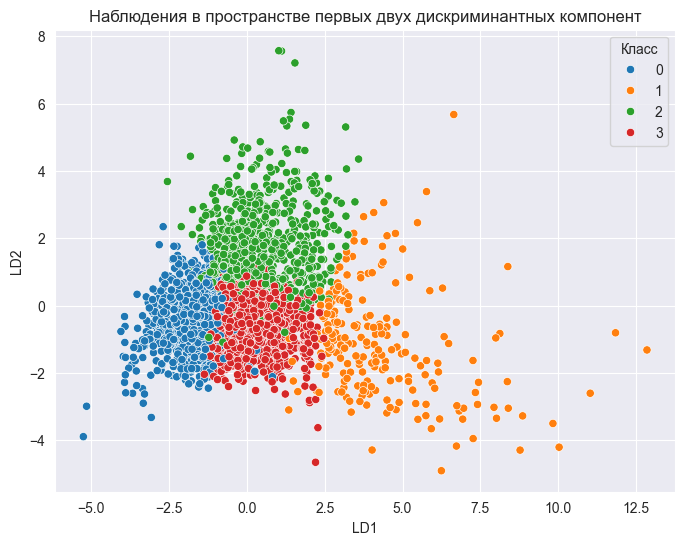

In [9]:
lda_transformed = lda.transform(X)
lda_df = pd.DataFrame(lda_transformed[:, :2], columns=['LD1', 'LD2'], index=data_fin.index)
lda_df['class'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='class', palette='tab10')
plt.title('Наблюдения в пространстве первых двух дискриминантных компонент')
plt.legend(title='Класс')
plt.show()


# **Вывод по графику рассеяния (LD1–LD2)**

-   В пространстве первых двух дискриминантных компонент наблюдается видимое разделение классов.  
    Классы **0** и **3** находятся ближе к краям, что объясняет низкие ошибки классификации для них.
    
-   Классы **1** и **2** занимают центральные области и **перекрываются между собой**.  
    Это подтверждает результаты ошибок: именно эти классы дают наибольший вклад в неверные классификации.
    
-   Компоненты LD1 и LD2 действительно содержат полезную информацию для разделения объектов — группы визуально различимы, хотя полностью разделить их линейно невозможно.
    

**Итог:** визуализация подтверждает выводы о качестве классификации: дискриминантные компоненты обеспечивают частичное, но не идеальное разделение классов, а основные трудности приходятся на средние классы (1 и 2).

In [10]:
errors_compare = reclass_df.set_index('Класс').join(
    exam_df.set_index('Класс'),
    how='inner'
)

errors_compare

,Условная вероятность ошибки,Условная вероятность ошибки (экзамен)
Класс,,
0,0.087291,0.064103
1,0.204444,0.227273
2,0.144776,0.223881
3,0.025465,0.029412


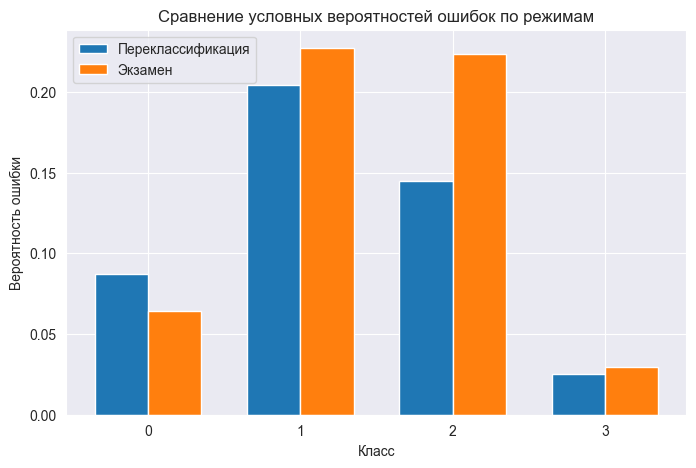

In [11]:
plt.figure(figsize=(8, 5))
x = np.arange(len(labels_sorted))
width = 0.35

plt.bar(x - width/2, errors_compare['Условная вероятность ошибки'], width, label='Переклассификация')
plt.bar(x + width/2, errors_compare['Условная вероятность ошибки (экзамен)'], width, label='Экзамен')

plt.xticks(x, labels_sorted)
plt.xlabel('Класс')
plt.ylabel('Вероятность ошибки')
plt.title('Сравнение условных вероятностей ошибок по режимам')
plt.legend()
plt.show()


# **Вывод по графику «Сравнение условных вероятностей ошибок»**

-   Ошибки переклассификации и «экзамена» ведут себя по-разному:  
    — в классах **1** и **2** вероятность ошибки заметно выше, чем в классах **0** и **3**;  
    — показатель на отложенной выборке («экзамен») ожидаемо немного выше, что связано с тем, что модель сталкивается с новыми данными.
    
-   Классы **1** и **2** оказываются **наиболее трудными для разделения**: именно там ошибка максимальна.  
    Это говорит о пересечении признаков у объектов этих классов.
    
-   Классы **0** и **3** классифицируются наиболее устойчиво:  
    вероятность ошибки остаётся низкой как в переклассификации, так и на экзамене.
    

**Итог:** Линейный дискриминантный анализ работает удовлетворительно, но имеет сложности с корректным разделением средних классов, где объекты сильнее «смешиваются» между собой.

# 6. Итоговые выводы

В ходе выполнения работы были решены следующие задачи:

1. Выполнен кластерный анализ в пространстве финансовых коэффициентов. На его основе сформированы четыре класса кредитоспособности предприятий.  
2. На основе этих классов построена модель линейного дискриминантного анализа и проведена переклассификация исходной выборки. Получены условные и безусловная вероятности ошибок для каждого класса и в среднем по выборке.  
3. Реализован режим «экзамена»: из каждого класса исключено по 10% наблюдений, по оставшимся данным обучена модель ЛДА и оценено качество прогноза на отложенной выборке.  
4. Визуализация в пространстве дискриминантных компонент показала разделимость классов, а сравнение вероятностей ошибок продемонстрировало снижение качества при переходе от переклассификации к экзаменационному режиму, что является ожидаемым.

Таким образом, линейный дискриминантный анализ позволяет использовать ранее полученную кластерную структуру для прогнозирования класса кредитоспособности новых наблюдений и оценки вероятностей ошибочной классификации.